This file contains the code used for implementing the classifer in paper Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring.

**Data Set**:
    - Train Data: 38 bone marrow samples(27 ALL, 11 AML); 6817 human genes expression level.
    - Test Data:
**Main Purpose**: Class prediction: using the built classifiers to predict the class of a new tumor sample.

- First load the data and transform it to make samples as rows and genes as columns. 
- Then add labels to the dataset with AML as 1 and ALL as 0.

[1]   38 7129

leuk.type
 0  1 
27 11 

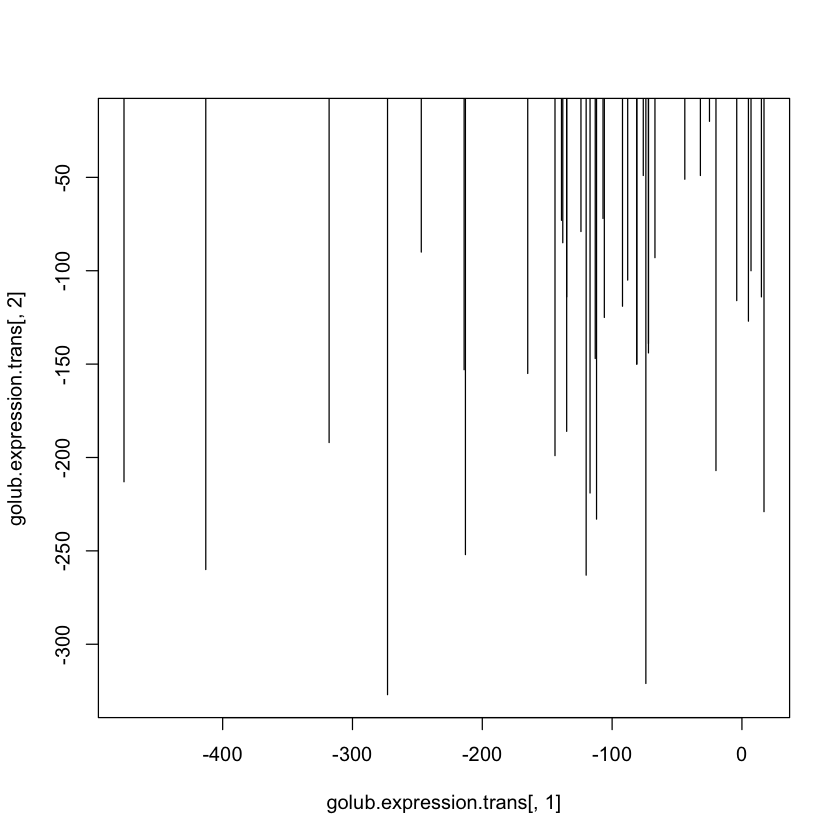

In [7]:
suppressMessages(library(golubEsets))
data("Golub_Train")
golub=Golub_Train
golub.expression = exprs(golub)
golub.expression.trans = t(golub.expression)
dim(golub.expression.trans)
golub.pheno=pData(golub)
leuk.type = factor(as.numeric(golub.pheno[,"ALL.AML"] == "AML"))
table(leuk.type)

- Check the combined data.

[1]   38 7130

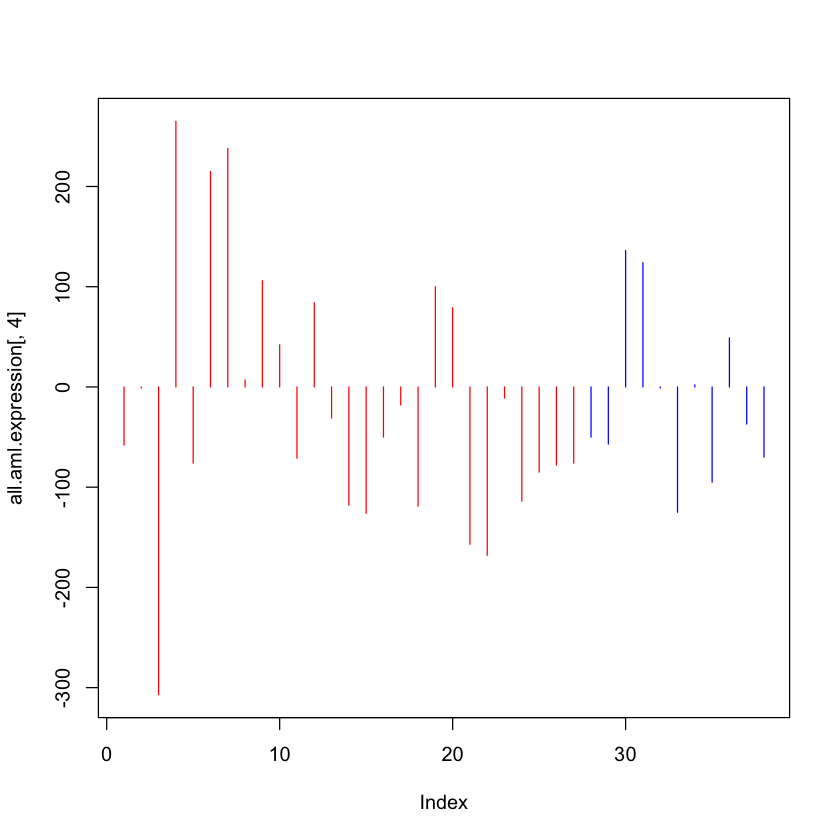

In [12]:
all.aml.expression = as.matrix(cbind(leuk.type, golub.expression.trans))
dim(all.aml.expression)
plot(all.aml.expression[,4], type = "h", col = (ifelse(all.aml.expression[,1]==1, "red", "blue")))

- Calculate mean, std of columns for different genes for the sample in group 1(AML), 0(ALL) respectively.

In [14]:
aml.mean.expression=colMeans(all.aml.expression[leuk.type == 1,-1])
aml.std.expression=apply(all.aml.expression[leuk.type == 1,-1], 2, sd)

all.mean.expression=colMeans(all.aml.expression[leuk.type == 0,-1])
all.std.expression=apply(all.aml.expression[leuk.type == 0,-1], 2, sd)

- Calculate P use the result before by $(\mu_{AML}-\mu_{ALL})/(\sigma_{AML} + \sigma_{ALL})$

In [18]:
 P = (aml.mean.expression-all.mean.expression)/(aml.std.expression+all.std.expression)
 p = P[c(head(order(P),25), head(order(P, decreasing = T), 25))]
 p[which(p>0)]

M55150_at   U50136_rna1_at        X95735_at        M16038_at 
       1.4676412        1.4217083        1.4057704        1.2029173 
       M23197_at        M84526_at        Y12670_at        U82759_at 
       1.1959743        1.1910386        1.1847369        1.1641602 
       D49950_at        M27891_at        X17042_at   U12471_cds1_at 
       1.1397895        1.1091898        1.1059750        1.0697309 
       U46751_at      Y00787_s_at        L08246_at        M80254_at 
       1.0640780        1.0409847        1.0347837        1.0277108 
       M62762_at        M81933_at   M96326_rna1_at M28130_rna1_s_at 
       1.0228516        1.0081928        1.0053719        1.0009166 
       M63138_at        M11147_at        M57710_at      M81695_s_at 
       0.9836280        0.9739522        0.9712892        0.9530658 
X85116_rna1_s_at 
       0.9461132

- Create classifier according to the paper, there were 25 genes selected as informative gene.

In [172]:
loc.class1.25gene=head(order(P),25)+1
loc.class2.25gene=head(order(P,decreasing = T),25)+1
Class1.25gene=all.aml.expression[,head(order(P),25)+1]
Class2.25gene=all.aml.expression[,head(order(P,decreasing = T),25)+1]

- Create the Classifier Matrix

In [156]:
Index = c(loc.class1.25gene, loc.class2.25gene)
tmp1 = aml.mean.expression[Index]
tmp2 = all.mean.expression[Index]
Classifier = rbind(p, (tmp1+tmp2)/2)
colnames(Classifier) = 1:50

- Performance on the training set

In [182]:
train.informative.gene = all.aml.expression[, Index]
dim(train.informative.gene)
predict = function(x){
    v = (train.informative.gene[x,] - Classifier[2,])*Classifier[1,]
    V = ifelse(v>0,1,0)
    (v1 = sum(v[V == 1]))
    (v2 = sum(abs(v[V == 0])))
    PS=round(abs(v1-v2)/(v1+v2),3)
    c(v1>v2, PS)
}
a = sapply(1:38, predict)
b = all.aml.expression[,1]
table(predict = a[1,], true = b)

[1] 38 50

       true
predict  1  2
      0 23  2
      1  4  9

[1] 0.077 0.100 0.099 0.168 0.059 0.296 0.239 0.160 0.015 0.346 0.187 0.312
[13] 0.014 0.247 0.054 0.067 0.029 0.429 0.184 0.256 0.018 0.368 0.366 0.070
[25] 0.063 0.160 0.367 0.096 0.410 0.365 0.354 0.060 0.185 0.062 0.223 0.123
[37] 0.164 0.298

- Predict test sample, use one sample first

In [176]:
data("Golub_Test")
test.golub=Golub_Test
test.golub.expression = t(exprs(test.golub))
dim(test.golub.expression)

[1]   34 7129

In [178]:
test.golub.pheno=pData(test.golub)
test.leuk.type = (test.golub.pheno[,"ALL.AML"] =="AML")
table(test.leuk.type)

test.all.aml.expression = as.matrix(cbind(test.leuk.type, test.golub.expression))
dim(test.all.aml.expression)

test.informative.gene=test.all.aml.expression[,Index]
dim(test.informative.gene)

test.leuk.type
FALSE  TRUE 
   20    14 

[1]   34 7130

[1] 34 50

- Calculate v_g for first sample in test data

In [179]:
v = (test.informative.gene[1,] - Classifier[2,])*p
V = ifelse(v>0,1,0)
(v1 = sum(V == 1))
(v2 = sum(V == 0))
(PS = abs(v1-v2)/(v1+v2))
test.all.aml.expression[2,1]

[1] 25

[1] 25

[1] 0

[1] 0

- Predict all samples in test dataset.

In [180]:
predict = function(x){
    v = (test.informative.gene[x,] - Classifier[2,])*p
    V = ifelse(v>0,1,0)
    (v1 = sum(v[V == 1]))
    (v2 = sum(abs(v[V == 0])))
    PS=round(abs(v1-v2)/(v1+v2),3)
    c(v1>v2, PS)
}
a = sapply(1:34, predict)
b = test.all.aml.expression[,1]
table(predict = a[1,], true = b)
#a[2,]

       true
predict  0  1
      0  2  0
      1 18 14

[1] 0.072 0.388 0.366 0.302 0.054 0.081 0.108 0.320 0.011 0.244 0.236 0.294
[13] 0.468 0.295 0.070 0.130 0.634 0.389 0.242 0.184 0.813 0.860 0.915 0.891
[25] 0.646 0.739 0.788 0.677 0.775 0.827 0.501 0.829 0.645 0.779